## Introduction to Color Conditioning

In this notebook, we will be focusing on **Color Conditioning** feature, which allows you to specify precise color values to control the color palette of generated images. Optionally, you may also supply a reference image to generate visuals that combine the specified color palette with the styling inherited from the reference.

### Use Case

OctankFashion knows that their customers care a lot about incorporating their perfect wedding colors into the apparel for their special day. OctankFashion's designers are excited to use AI to help them design fun and colorful accessories, starting with new line of patterned bow ties.


<div class="alert alert-block alert-warning">
<b>Prerequisites:</b> Please run the prerequiresites <b>00-prerequisites.ipynb</b> first before proceeding.
</div>


In [1]:
import io
import json
import base64
import boto3
from botocore.config import Config
from PIL import Image
from utils import (
    save_image,
    plot_color_conditioning,
    plot_images_for_comparison,
    create_color_palette_image,
)
from string import Template

bedrock_runtime_client = boto3.client(
    "bedrock-runtime",
    region_name="us-east-1",
    config=Config(
        read_timeout=5 * 60
    ),  # IMPORTANT: Increase the read timeout to 5 minutes to support longer operations.
)
image_generation_model_id = "amazon.nova-canvas-v1:0"
output_dir = "output"

### Example 1: Color conditioning with color values

Color conditioning enables control over the color palette of generated images by providing a list of colors expressed as hexidecimal color codes. This is useful for adhering to brand guidelines or specific design requirements.

In the code below, we define a prompt template that lets us generate a number of different patterned bow ties. The `colors` list defines the exact colors we want to incorporate into each design.

Run the cells below to generate some bowtie designs. The generated images will be saved to the "output" folder.


In [2]:
# Define a prompt template and a set of "pattern" values that will be used with the template.
prompt_template = Template("a patterned bowtie, $pattern, on solid white background")
patterns = ["paisley", "striped", "floral"]

# Define the main input parameters.
colors = ["#FFFFFF", "#FF9900", "#F2F2F2", "#232F3E"]
seed = 35

Generating image 1 of 3...
Saved image to output/07-color-conditioning_pattern-paisley.png
Generating image 2 of 3...
Saved image to output/07-color-conditioning_pattern-striped.png
Generating image 3 of 3...
Saved image to output/07-color-conditioning_pattern-floral.png


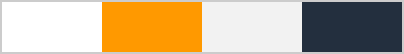

Prompt: a patterned bowtie, #pattern, on solid white background



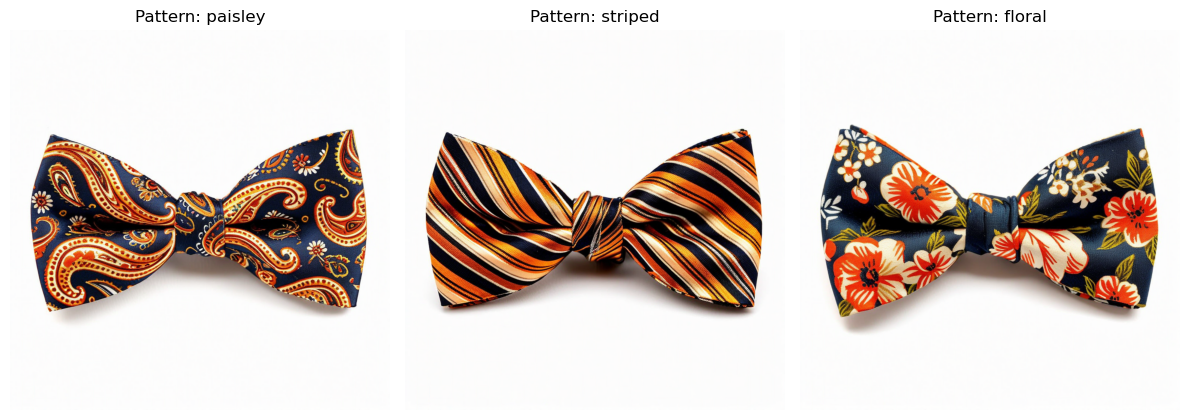

In [3]:
generated_images = []

# Generate images for each pattern.
for index, pattern in enumerate(patterns):

    # Generate image condition on color palette
    body = json.dumps(
        {
            "taskType": "COLOR_GUIDED_GENERATION",
            "colorGuidedGenerationParams": {
                "text": prompt_template.substitute({"pattern": pattern}),
                "colors": colors,
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,  # Number of images to generate, up to 5
                "cfgScale": 6.5,  # How closely the prompt will be followed
                "width": 1024,
                "height": 1024,
                "seed": seed,
                "quality": "standard",  # Quality of either "standard" or "premium"
            },
        }
    )

    print(f"Generating image {index + 1} of {len(patterns)}...")

    response = bedrock_runtime_client.invoke_model(
        body=body,
        modelId=image_generation_model_id,
        accept="application/json",
        contentType="application/json",
    )

    response_body = json.loads(response.get("body").read())

    base64_images = response_body.get("images")
    image_path = f"{output_dir}/07-color-conditioning_pattern-{pattern}.png"
    save_image(base64_images[0], image_path)
    print(f"Saved image to {image_path}")

    generated_img = [
        Image.open(io.BytesIO(base64.b64decode(base64_image)))
        for base64_image in base64_images
    ]
    generated_images.append(generated_img[0])

# Display the color palette.
color_palette_image = create_color_palette_image(
    colors, width=400, height=50, border_color="#cccccc", border_width=2
)
display(color_palette_image)

# Plot comparison images
plot_images_for_comparison(
    generated_images=generated_images,
    labels=patterns,
    prompt=prompt_template.substitute({"pattern": "#pattern"}),
    comparison_mode=True,
    title_prefix="Pattern:",
)

<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Change the color values (up to 10) to define your own color palette. You can use the online <a href="https://g.co/kgs/98bBfY5" target="_blank">Google Color Picker</a> to select a color and get it's hex value. Try editing the styles list to define your own styles.
</div>


# Take Away

The Nova Canvas color conditioning feature allows customers to control the color palette of generated images, whether to adhere to a brand style guide or simply to gain more control over the final image look.

We encourage users to explore these new functionalities within Amazon Bedrock to experience the expanded potential for creating precise, customized visual contents.
